In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE 
import pickle
import warnings
warnings.filterwarnings("ignore") 

# --- Configuration ---
CLEAN_DATA_FILE = 'fraud_Train_cleaned_.csv'
TARGET_COLUMN = 'is_fraud'

In [2]:
# Load the preprocessed data
try:
    df = pd.read_csv(CLEAN_DATA_FILE)
    print(f"Cleaned data '{CLEAN_DATA_FILE}' loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: '{CLEAN_DATA_FILE}' not found. Please run '1_Preprocessing.ipynb' first.")

df.head()

Cleaned data 'fraud_Train_cleaned_.csv' loaded successfully. Shape: (1296675, 74)


,amt,gender,zip,city_pop,unix_time,is_fraud,hour,day_of_week,month,age,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,4.97,0,28654,3495,1325376018,0,0,1,1,30,...,0,0,0,0,0,0,0,0,0,0
1,107.23,0,99160,149,1325376044,0,0,1,1,40,...,0,0,0,0,0,0,1,0,0,0
2,220.11,1,83252,4154,1325376051,0,0,1,1,56,...,0,0,0,0,0,0,0,0,0,0
3,45.00,1,59632,1939,1325376076,0,0,1,1,51,...,0,0,0,0,0,0,0,0,0,0
4,41.96,1,24433,99,1325376186,0,0,1,1,32,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# Separate features and target
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN], errors='ignore')

print(f"Features: {X.shape[1]}, Target: {y.name}")

Features: 73, Target: is_fraud


In [4]:
# Split before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure fraud ratio is maintained
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1037340, 73)
Testing set shape: (259335, 73)


In [5]:
# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data with the same scaler
X_test_scaled = scaler.transform(X_test)

print("Data scaled successfully.")

Data scaled successfully.


In [6]:
# Apply SMOTE only to the training data
print("Applying SMOTE to training data...")
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(y_train_res.value_counts())

Applying SMOTE to training data...
Class distribution after SMOTE:
is_fraud
0    1031335
1    1031335
Name: count, dtype: int64


In [7]:
print("--- 1. Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_res, y_train_res)
rf_predictions = rf_model.predict(X_test_scaled)
rf_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]

print("--- 2. Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_res, y_train_res)
lr_predictions = lr_model.predict(X_test_scaled)
lr_probabilities = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Models trained.")

--- 1. Training Random Forest ---
--- 2. Training Logistic Regression ---
Models trained.


In [8]:
# Dictionary to store results
results = {}

def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n--- {model_name} Results ---")
    
    auc_score = roc_auc_score(y_true, y_prob)
    results[model_name] = {
        'Recall': classification_report(y_true, y_pred, output_dict=True)['1']['recall'],
        'Precision': classification_report(y_true, y_pred, output_dict=True)['1']['precision'],
        'F1-Score': classification_report(y_true, y_pred, output_dict=True)['1']['f1-score'],
        'AUC-ROC': auc_score
    }
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Valid (0)', 'Fraud (1)']))
    print(f"AUC-ROC Score: {auc_score:.4f}")

# Evaluate both models
evaluate_model("Random Forest", y_test, rf_predictions, rf_probabilities)
evaluate_model("Logistic Regression", y_test, lr_predictions, lr_probabilities)


--- Random Forest Results ---

Classification Report:
              precision    recall  f1-score   support

   Valid (0)       1.00      1.00      1.00    257834
   Fraud (1)       0.89      0.81      0.85      1501

    accuracy                           1.00    259335
   macro avg       0.95      0.91      0.93    259335
weighted avg       1.00      1.00      1.00    259335

AUC-ROC Score: 0.9932

--- Logistic Regression Results ---

Classification Report:
              precision    recall  f1-score   support

   Valid (0)       1.00      0.88      0.94    257834
   Fraud (1)       0.04      0.76      0.07      1501

    accuracy                           0.88    259335
   macro avg       0.52      0.82      0.50    259335
weighted avg       0.99      0.88      0.93    259335

AUC-ROC Score: 0.9149



FINAL MODEL COMPARISON
|                     |   Recall |   Precision |   F1-Score |   AUC-ROC |
|:--------------------|---------:|------------:|-----------:|----------:|
| Random Forest       |   0.8141 |      0.8933 |     0.8519 |    0.9932 |
| Logistic Regression |   0.7615 |      0.0361 |     0.0689 |    0.9149 |


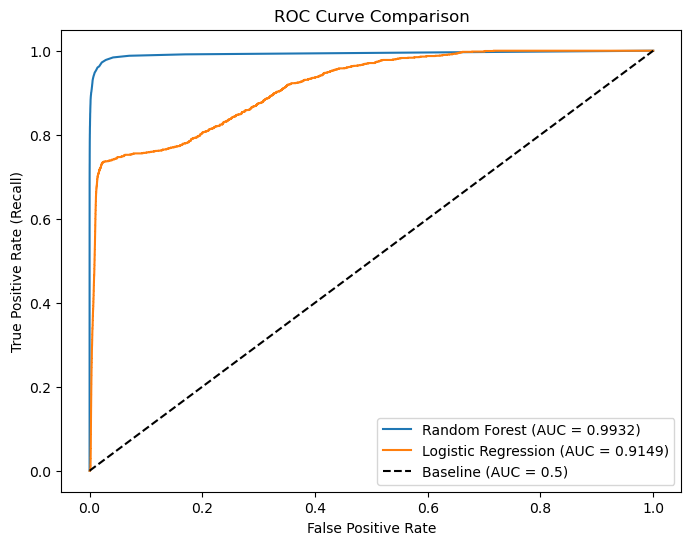

In [9]:
# --- Final Comparison Table ---
comparison_df = pd.DataFrame(results).T
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)
print(comparison_df.sort_values(by='Recall', ascending=False).to_markdown(floatfmt=".4f"))

# --- Plotting ROC Curves ---
plt.figure(figsize=(8, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {results["Random Forest"]["AUC-ROC"]:.4f})')
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probabilities)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {results["Logistic Regression"]["AUC-ROC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [12]:
print("\n--- Saving Final Model, Scaler, and Features ---")

# Get the feature names from the dataframe *before* scaling
model_features = X.columns.tolist() 

# 1. Save the best model (Random Forest)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to rf_model.pkl")

# 2. Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to scaler.pkl")

# 3. Save the feature list (THIS IS THE FIX)
with open('model_features.pkl', 'wb') as f:
    pickle.dump(model_features, f)
print(f"Feature list saved to model_features.pkl")


--- Saving Final Model, Scaler, and Features ---
Model saved to rf_model.pkl
Scaler saved to scaler.pkl
Feature list saved to model_features.pkl
